# Test evaluations

In [1]:
from os.path import realpath
from pathlib import Path
import pandas as pd
import itertools
import json
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

def load_json(path):
    with open(path) as f:
        cfg = json.load(f)
    return cfg

RUNS_DIR = Path(realpath('.')) / 'runs'
if not 'domain-adaptation/runs' in str(RUNS_DIR):
    RUNS_DIR = Path(realpath('.')).parent / 'runs'
assert('domain-adaptation/runs' in str(RUNS_DIR))

In [2]:
def load_cls_rep_paths_new(
    method,
    experiment_id,
    prefix=None,
    config_dict={},
):
    d = RUNS_DIR / method / experiment_id
    paths = []
    for item in d.glob('*'):
        if (item.is_dir()):
            if config_dict:
                config = load_json(item / 'config.json')
                if not all([config[k]==v for k,v in config_dict.items()]):
                    continue
            if prefix:
                if not item.name.startswith(prefix):
                    continue
            paths.append( item / 'report.json' ) 
    return sorted(paths)

def get_score_new(
    report_paths,
    metric:str='precision',
    avg_types=['macro avg', 'weighted avg'],
    map_col_name= lambda n: n
):
    reports = [ pd.read_json(p) for p in report_paths ]
    score = pd.DataFrame(
        [[r[avgt][metric] for avgt in avg_types]
         for r in reports
        ],
        columns = [ map_col_name(avgt) for avgt in avg_types]
    ) 
    return score


def get_score_combinations_new(
    method,
    experiment_id,
    config_key=None,
    config_value=None,
    config_dict={},
    domains=['A','W','D'], 
    metric:str='recall',
    avg_types=['macro avg'],
):
    if config_key and config_value:
        config_dict[config_key] = config_value
        
    combos = [c for c in itertools.product(domains, repeat=2) if c[0] != c[1]]
    scores = [
        get_score_new(
            report_paths=load_cls_rep_paths_new(method, experiment_id, '{}{}'.format(c[0],c[1]), config_dict),
            metric=metric,
            avg_types=avg_types,
            map_col_name=lambda n: '{}->{}'.format(c[0],c[1]),
        )
        for c in combos
    ]
    return pd.concat(scores, sort=False)


def present(df, name):
    df = df.describe().T[['mean','std']]
    tot_mean = df.mean()[['mean']]
    
    toStr = lambda s: f'{s:.2f}'
    df = df['mean'].map(toStr) + ' ±' + df['std'].map(toStr)
    df = pd.concat([df,tot_mean[['mean']]])
    return pd.DataFrame(df, columns=[name]).T


def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

## Tune source only
In this experiment, we tune a VGG16-network pretrained on ImageNet with all available source data.
The target data is used for validation (during training) and test.

In [12]:
tune_source_no_aug_scores = get_score_combinations_new(
    method='tune_source',
    experiment_id='tune_source_no_aug',
)*100
tune_source_no_aug_scores.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,62.255293,2.876099,58.703566,60.118168,62.317043,64.882089,65.255601
A->W,5.0,53.909982,1.816761,51.745806,52.443511,54.047886,55.303047,56.009660
D->A,5.0,37.601127,2.356256,34.128049,36.512041,38.335136,38.775862,40.254545
D->W,5.0,90.982524,2.225432,87.885781,89.989964,90.893983,92.571363,93.571528
W->A,5.0,42.579908,1.533883,40.575395,41.629445,42.976339,43.131344,44.587021
W->D,5.0,98.707230,0.655752,98.064412,98.263400,98.634153,98.822325,99.751861


In [13]:
tune_source_scores = get_score_combinations_new(
    method='tune_source',
    experiment_id='tune_source_with_aug',
)*100
tune_source_scores.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,65.859347,2.230132,63.796151,64.761948,65.003669,66.188868,69.546098
A->W,5.0,56.567206,2.084737,53.898678,54.758035,57.814545,57.853058,58.511712
D->A,5.0,41.696940,1.640651,39.190639,41.082026,42.081671,42.737236,43.393128
D->W,5.0,92.875348,1.169019,90.854845,92.890177,93.381241,93.585405,93.665070
W->A,5.0,41.163056,2.133029,38.413584,40.117469,40.801652,42.617711,43.864865
W->D,5.0,98.691223,0.818735,97.452336,98.443617,98.762161,99.201229,99.596774


### Gradual Unfreeze Fine-tuning

In [14]:
ft_src_grad_unf_0_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_0',
)*100
ft_src_grad_unf_0_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,65.889501,3.74535,60.472616,63.650057,67.380143,68.460982,69.483704


In [15]:
ft_src_grad_unf_2_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_2',
)*100
ft_src_grad_unf_2_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.078229,2.801691,62.942111,65.876221,67.375394,69.438023,69.759397


In [16]:
ft_src_grad_unf_3_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_3',
)*100
ft_src_grad_unf_3_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.732249,2.62079,64.545128,65.210037,69.486343,69.542442,69.877297


In [17]:
ft_src_grad_unf_4_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_4',
)*100
ft_src_grad_unf_4_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.735473,2.193459,64.569827,66.44739,68.603821,69.090516,69.96581


In [19]:
ft_src_grad_unf_6_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_6',
)*100
ft_src_grad_unf_6_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.954058,1.763461,65.899232,67.503943,67.67719,67.918712,70.771212


In [20]:
ft_src_grad_unf_7_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_7',
)*100
ft_src_grad_unf_7_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,68.33378,2.303235,65.440109,66.380372,69.232904,69.844706,70.770809


In [21]:
ft_src_grad_unf_8_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_8',
)*100
ft_src_grad_unf_8_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,68.730472,2.277957,65.965728,67.05596,68.693416,70.58883,71.348427


In [22]:
ft_src_grad_unf_10_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_10',
)*100
ft_src_grad_unf_10_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,4.0,69.595584,2.435421,66.165178,69.075152,70.150045,70.670477,71.917067


In [23]:
ft_src_grad_unf_11_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_11',
)*100
ft_src_grad_unf_11_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,4.0,69.571248,1.186921,68.231463,68.911341,69.50811,70.168017,71.037308


In [24]:
ft_src_grad_unf_12_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_12',
)*100
ft_src_grad_unf_12_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,4.0,70.071983,0.610344,69.325293,69.700486,70.169348,70.540845,70.623943


### Coarse gradual unfreeze

In [26]:
tune_source_vgg16_aug_coarse_grad = get_score_combinations_new(
    method='tune_source',
    experiment_id='vgg16_aug_coarse_grad_ft',
)*100
tune_source_vgg16_aug_coarse_grad.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,66.636605,2.966424,61.512586,66.844356,67.688503,68.164576,68.973006
A->W,5.0,59.793897,2.125821,57.034714,59.304191,59.575454,60.084539,62.970588
D->A,5.0,42.816493,5.218414,33.990533,42.159687,45.591694,45.722539,46.618014
D->W,5.0,92.333845,2.764590,88.024718,91.065796,94.105682,94.148213,94.324815
W->A,5.0,43.998664,0.658633,43.309881,43.468084,44.044374,44.205728,44.965251
W->D,5.0,98.540254,1.236710,97.172397,97.742034,98.109417,99.677419,100.000000


In [28]:
tune_source_resnet101_aug_coarse_grad = get_score_combinations_new(
    method='tune_source',
    experiment_id='resnet101v2_aug_coarse_grad_ft',
)*100
tune_source_resnet101_aug_coarse_grad.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,72.751316,1.454845,71.240210,71.955371,72.341727,73.189988,75.029284
A->D,5.0,74.969336,1.329631,73.364764,73.919061,75.074968,75.985552,76.502338
W->A,5.0,59.596429,1.113659,58.532945,58.585823,59.465619,60.274189,61.123567
W->D,5.0,97.773171,0.733757,96.847018,97.292184,97.735732,98.396254,98.594667
D->A,5.0,60.118268,0.897086,59.117722,59.499037,59.863154,60.978827,61.132598
D->W,5.0,93.719617,1.281476,92.249463,92.427076,94.390690,94.543016,94.987839


### Comparison

In [33]:
grad_unfreeze_source_results = pd.DataFrame({ 
    '0'  : ft_src_grad_unf_0_vgg16['A->D'],
    '2'  : ft_src_grad_unf_2_vgg16['A->D'],
    '3'  : ft_src_grad_unf_3_vgg16['A->D'],
    '4'  : ft_src_grad_unf_4_vgg16['A->D'],
    '6'  : ft_src_grad_unf_6_vgg16['A->D'],
    '7'  : ft_src_grad_unf_7_vgg16['A->D'],
    '8'  : ft_src_grad_unf_8_vgg16['A->D'],
    '10' : ft_src_grad_unf_10_vgg16['A->D'],
    '11' : ft_src_grad_unf_11_vgg16['A->D'],
    '12' : ft_src_grad_unf_12_vgg16['A->D'],
#     '12_coarse'  : tune_source_vgg16_aug_coarse_grad['A->D'].dropna(),
})

grad_unfreeze_source_results

,0,2,3,4,6,7,8,10,11,12
0,63.650057,62.942111,65.210037,66.447390,67.918712,65.440109,67.055960,66.165178,68.231463,69.325293
1,60.472616,65.876221,64.545128,64.569827,65.899232,66.380372,65.965728,70.045143,69.137966,70.623943
2,67.380143,67.375394,69.486343,68.603821,67.677190,69.844706,70.588830,70.254947,71.037308,69.825551
3,69.483704,69.759397,69.877297,69.090516,70.771212,70.770809,71.348427,71.917067,69.878254,70.513146
4,68.460982,69.438023,69.542442,69.965810,67.503943,69.232904,68.693416,NaN,NaN,NaN


In [34]:
grad_unfreeze_source_results.describe().T

,count,mean,std,min,25%,50%,75%,max
0,5.0,65.889501,3.745350,60.472616,63.650057,67.380143,68.460982,69.483704
2,5.0,67.078229,2.801691,62.942111,65.876221,67.375394,69.438023,69.759397
3,5.0,67.732249,2.620790,64.545128,65.210037,69.486343,69.542442,69.877297
4,5.0,67.735473,2.193459,64.569827,66.447390,68.603821,69.090516,69.965810
6,5.0,67.954058,1.763461,65.899232,67.503943,67.677190,67.918712,70.771212
7,5.0,68.333780,2.303235,65.440109,66.380372,69.232904,69.844706,70.770809
8,5.0,68.730472,2.277957,65.965728,67.055960,68.693416,70.588830,71.348427
10,4.0,69.595584,2.435421,66.165178,69.075152,70.150045,70.670477,71.917067
11,4.0,69.571248,1.186921,68.231463,68.911341,69.508110,70.168017,71.037308
12,4.0,70.071983,0.610344,69.325293,69.700486,70.169348,70.540845,70.623943


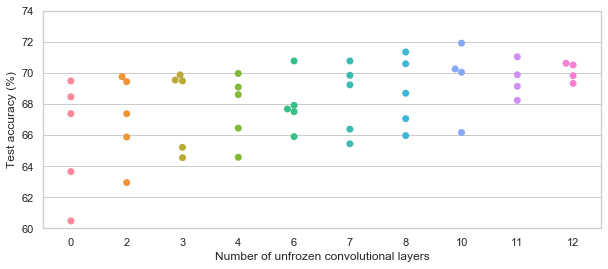

In [35]:
plt.figure(figsize=(10,4))
sns.set()
sns.set_style("whitegrid")
sns.set_palette("Spectral")
# ax = sns.violinplot(data=grad_unfreeze_source_results, width=1)
# ax = sns.boxplot(data=grad_unfreeze_source_results, width=0.5)
# ax = sns.swarmplot(data=grad_unfreeze_source_results, color="0.25")
ax = sns.swarmplot(data=grad_unfreeze_source_results, size=7)
plt.xlabel('Number of unfrozen convolutional layers')
plt.ylabel('Test accuracy (%)')
plt.ylim((60,74))
plt.savefig('gradual-unfreeze-AD.pdf')  

## Tune source and target

### Coarse gradual unfreeze 

In [38]:
tune_target_vgg16_aug_coarse_grad_ft = get_score_combinations_new(
    method='tune_target',
    experiment_id='vgg16_aug_coarse_grad_ft',
)*100
tune_target_vgg16_aug_coarse_grad_ft.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,71.354832,2.047845,69.217956,69.598614,71.136240,72.852380,73.968967
A->W,5.0,73.989078,4.948449,70.062192,71.046410,71.095686,75.883947,81.857153
D->A,5.0,56.201621,3.611262,53.372360,53.476973,54.126970,58.724620,61.307181
D->W,5.0,95.869260,1.167603,95.146474,95.190651,95.300098,95.804594,97.904483
W->A,5.0,50.226811,2.631192,46.918136,48.885330,49.591069,52.335316,53.404202
W->D,5.0,99.108672,0.806583,97.709293,99.327620,99.354030,99.354030,99.798387


In [40]:
tune_target_resnet101v2_aug_coarse_grad_ft = get_score_combinations_new(
    method='tune_target',
    experiment_id='resnet101v2_aug_coarse_grad_ft',
)*100
tune_target_resnet101v2_aug_coarse_grad_ft.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,6.0,86.200014,1.825390,84.220063,85.121348,85.722943,86.918689,89.296046
A->W,5.0,86.637348,1.054278,84.906934,86.629824,86.729457,87.249601,87.670926
D->A,5.0,62.905532,1.268804,61.641015,61.780017,62.662449,64.067289,64.376890
D->W,5.0,94.625185,0.317125,94.348822,94.413338,94.498291,94.738139,95.127337
W->A,5.0,60.932032,0.721214,60.024654,60.404908,61.155426,61.224453,61.850721
W->D,5.0,98.268413,0.487107,97.440673,98.249685,98.422594,98.604908,98.624207


## CCSA

### Flip test
Using CCSA with alpha=0.25, FE VGG16, adam, lr=1e-4, batch size=16

In [66]:
# regular training setup with even weighting of source and target cross entropies
ccsa_flip_test_regular_even = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_regular_even',
)*100
ccsa_flip_test_regular_even.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,57.120339,1.833822,53.94533,57.26043,57.699354,58.335678,58.360902


In [65]:
# train a batch, flip source and target, the train on the same batch again. Here, we only weight the ce from the first branch
ccsa_flip_test_flipping_uneven = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_flipping_uneven',
)*100
ccsa_flip_test_flipping_uneven.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,58.602653,1.842668,56.532795,56.857532,58.908489,60.331202,60.383249


In [63]:
# train a batch, flip source and target, the train on the same batch again. Here, weight both branches equally. We test an optimized implementation here
ccsa_flip_test_repeat_even = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_repeat_even',
)*100
ccsa_flip_test_repeat_even.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,60.196115,1.03347,58.605917,59.783347,60.468873,61.030215,61.092225


In [67]:
pd.concat([
    present(ccsa_flip_test_regular_even, 'No flip'),
    present(ccsa_flip_test_flipping_uneven, 'Flip, batch repeat'),
    present(ccsa_flip_test_repeat_even, 'No flip, batch repeat'),
])    

,W->A,mean
No flip,57.12 ±1.83,57.1203
"Flip, batch repeat",58.60 ±1.84,58.6027
"No flip, batch repeat",60.20 ±1.03,60.1961


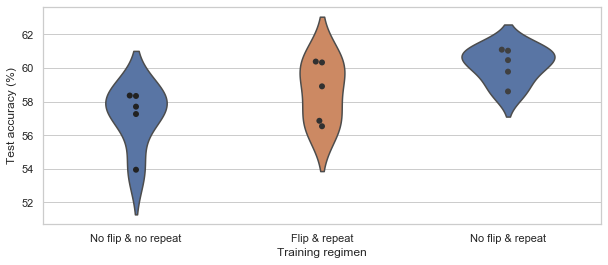

In [68]:
def get_batch_size_results(datasets='W->A'):
    def mod(df, method:str, column=datasets):
        df = df[column].rename('acc').to_frame()
        df['Method'] = method
        return df

    results = pd.concat([
        mod(ccsa_flip_test_regular_even, 'No flip & no repeat'),
        mod(ccsa_flip_test_flipping_one, 'Flip & repeat'),
        mod(ccsa_flip_test_v2_even, 'No flip & repeat'),
    ])    
    return results

res = get_batch_size_results()

plt.figure(figsize=(10,4))
sns.set()
sns.set_style("whitegrid")
# sns.set_palette("Set2")
ax = sns.violinplot(x='Method', y='acc', hue=None, data=res, width=0.5, inner=None, palette=sns.color_palette(None, 2))
ax = sns.swarmplot(x='Method', y='acc', hue='Method', data=res, size=6, color='0.25')
plt.xlabel('Training regimen')
plt.ylabel('Test accuracy (%)')
ax.get_legend().remove()
plt.savefig('flip-experiment-violin-WA.pdf') 

### Batch repeat experiments
It seems like simply repeating a batch twice is better than doing the flipping.
Here, we test if using even more repeats is helpfull

Using CCSA with alpha=0.25, FE VGG16, adam, lr=1e-4, batch size=16

In [69]:
ccsa_batch_repeat_1 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_1',
)*100
ccsa_batch_repeat_1.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,58.071556,1.702833,55.90954,56.525195,58.133948,58.976027,60.813557


In [70]:
ccsa_batch_repeat_2 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_2',
)*100
ccsa_batch_repeat_2.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,60.091863,1.240636,57.82751,59.640544,59.877626,60.390899,62.508862


In [71]:
ccsa_batch_repeat_3 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_3',
)*100
ccsa_batch_repeat_3.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,60.543938,1.3893,57.898631,59.801906,60.573028,61.586225,62.283153


In [72]:
ccsa_batch_repeat_4 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_4',
)*100
ccsa_batch_repeat_4.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,59.586337,1.252654,58.040551,58.583682,59.167775,60.821302,61.38946


In [73]:
ccsa_batch_repeat_5 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_5',
)*100
ccsa_batch_repeat_5.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,59.671694,1.065709,58.170005,58.941079,59.568249,60.360456,61.189369


In [74]:
ccsa_batch_repeat_10 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_10',
)*100
ccsa_batch_repeat_10.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,59.708881,1.33977,57.214923,58.961334,59.617865,60.803057,61.412026


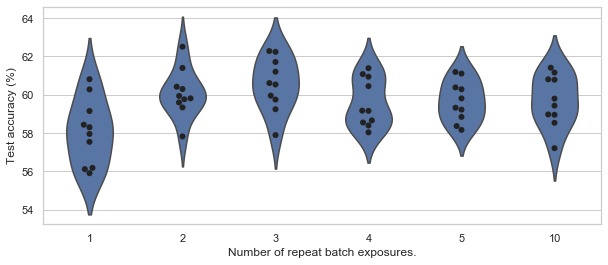

In [75]:
def mod(df, repeats:float, method:str, column='W->A'):
    df = df[column].rename('acc').to_frame()
    df['repeats'] = repeats
    df['method'] = method
    df
    return df

batch_repeat_results = pd.concat([
    mod(ccsa_batch_repeat_1, 1, 'ccsa'),
    mod(ccsa_batch_repeat_2, 2, 'ccsa'),
    mod(ccsa_batch_repeat_3, 3, 'ccsa'),
    mod(ccsa_batch_repeat_4, 4, 'ccsa'),
    mod(ccsa_batch_repeat_5, 5, 'ccsa'),
    mod(ccsa_batch_repeat_10, 10, 'ccsa'),
])

plt.figure(figsize=(10,4))
sns.set()
sns.set_style("whitegrid")
# sns.set_palette("Set2")
ax = sns.violinplot(x='repeats', y='acc', hue='method',  data=batch_repeat_results, width=0.5, inner=None)
ax = sns.swarmplot(x='repeats', y='acc', hue='method', data=batch_repeat_results, size=6, color='0.25')
plt.xlabel('Number of repeat batch exposures.')
plt.ylabel('Test accuracy (%)')
# plt.legend(loc='upper right')
ax.get_legend().remove()
plt.savefig('batch-repeat-WA.pdf') 

### Alpha search light
FE VGG16, adam, lr=1e-4, even loss weighting, regular training

In [82]:
multitask_light = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0,
)*100
multitask_light.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,30.0,58.624724,24.208588,16.400275,29.502511,68.823619,79.839063,83.220698
W->A,35.0,44.267316,20.170874,13.507745,19.715839,57.160519,61.482040,63.566039


In [83]:
ccsa_alpha_search_light005 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.05,
)*100
ccsa_alpha_search_light005.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,62.288967,0.906074,61.419358,61.544722,62.079112,62.835602,63.566039


In [84]:
ccsa_alpha_search_light01 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.1,
)*100
ccsa_alpha_search_light01.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.409309,0.860050,79.473432,79.960940,80.278793,80.567709,81.765672
W->A,5.0,61.443243,0.424543,60.856024,61.266003,61.415474,61.716641,61.962076


In [85]:
ccsa_alpha_search_light025 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.25,
)*100
ccsa_alpha_search_light025.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.134343,3.229596,74.323845,78.694226,79.005656,80.427290,83.220698
W->A,5.0,57.554486,2.154422,54.883009,56.433084,57.160519,58.856791,60.439029


In [86]:
ccsa_alpha_search_light05 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.5,
)*100
ccsa_alpha_search_light05.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,58.395793,3.288602,55.207917,55.804034,57.890245,59.753379,63.323392
W->A,5.0,32.552409,3.194693,28.485366,31.661489,32.394323,32.832533,37.388337


In [87]:
ccsa_alpha_search_light075 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.75,
)*100
ccsa_alpha_search_light075.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,28.089171,2.304633,24.090007,28.152808,29.165656,29.486330,29.551054
W->A,5.0,17.954809,2.601132,13.507745,17.908602,18.926017,19.451885,19.979794


In [88]:
ccsa_alpha_search_light09 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.9,
)*100
ccsa_alpha_search_light09.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,25.893177,5.557179,16.400275,27.021397,27.294982,27.651973,31.097259
W->A,5.0,15.964302,1.663536,14.463343,15.115335,15.251589,16.291889,18.699356


### Batch size
FE VGG16, adam, even loss weighting, regular training, alpha=0.1

In [89]:
ccsa_bs_16 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 16,
        'learning_rate': 1e-4
    },
)*100
ccsa_bs_64 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 64,
        'learning_rate': 1e-4
    },
)*100
ccsa_bs_256 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 256,
        'learning_rate': 1e-4
    },
)*100
ccsa_bs_1024 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 1024,
        'learning_rate': 1e-4
    },
)*100
ccsa_bs_4096 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 4096,
        'learning_rate': 1e-4
    },
)*100

In [90]:
ccsa_bs_64_comp = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 64,
        'learning_rate': 2e-4
    },
)*100
ccsa_bs_256_comp = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 256,
        'learning_rate': 4e-4
    },
)*100
ccsa_bs_1024_comp = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 1024,
        'learning_rate': 8e-4
    },
)*100
ccsa_bs_4096_comp = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 4096,
        'learning_rate': 16e-4
    },
)*100

## d-SNE

### Alpha search light
FE VGG16, adam, lr=1e-4, even loss weighting, regular training

In [96]:
dsne_alpha_search_light005 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.05,
)*100
dsne_alpha_search_light005.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,62.135216,0.680315,61.244821,61.693374,62.192311,62.619435,62.926137


In [97]:
dsne_alpha_search_light01 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.1,
)*100
dsne_alpha_search_light01.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.368500,1.398707,79.158679,79.634119,79.925686,80.383548,82.740469
W->A,5.0,61.498817,1.006403,60.414948,60.767062,61.533149,61.775678,63.003251


In [98]:
dsne_alpha_search_light025 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.25,
)*100
dsne_alpha_search_light025.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.559941,1.595350,78.611114,79.321343,80.804848,81.551967,82.510433
W->A,5.0,61.367479,1.965252,58.660601,60.734580,61.065922,62.480853,63.895437


In [99]:
dsne_alpha_search_light05 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.5,
)*100
dsne_alpha_search_light05.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.904192,1.274271,79.494130,79.694081,81.196612,81.716147,82.419991
W->A,5.0,59.946678,0.338412,59.562761,59.618146,60.046430,60.202458,60.303597


In [100]:
dsne_alpha_search_light075 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.75,
)*100
dsne_alpha_search_light075.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.85709,2.214712,76.821830,78.208415,81.100647,81.242357,81.912200
W->A,5.0,53.35842,2.606840,50.069184,52.004812,52.707790,55.784495,56.225818


In [101]:
dsne_alpha_search_light09 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.9,
)*100
dsne_alpha_search_light09.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,78.955045,2.647625,76.156565,77.780654,78.432462,79.147128,83.258417
W->A,5.0,43.916090,3.007585,39.148697,43.453899,44.005703,46.378974,46.593176


## DAGE

### Alpha search light
FE VGG16, adam, lr=1e-4, even loss weighting, regular training

In [3]:
dage_alpha_light_005 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.05,
)*100
dage_alpha_light_005.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,61.824511,0.637514,61.103089,61.259799,61.874568,62.342813,62.542288


In [4]:
dage_alpha_light_01 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.1,
)*100
dage_alpha_light_01.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.351082,1.018320,78.177440,78.894762,78.958479,79.936500,80.788228
W->A,5.0,62.108532,0.706549,61.235364,61.619967,62.120676,62.577312,62.989340


In [5]:
dage_alpha_light_025 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.25,
)*100
dage_alpha_light_025.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.763302,0.854267,79.100354,79.148466,79.216051,80.414380,80.937260
W->A,5.0,62.006840,0.913827,60.677038,61.644253,62.062637,62.603608,63.046663


In [6]:
dage_alpha_light_05 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.5,
)*100
dage_alpha_light_05.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.217185,1.769092,76.676912,78.769645,79.025789,80.184230,81.429347
W->A,5.0,61.708957,0.252436,61.429160,61.438943,61.859960,61.882134,61.934589


In [7]:
dage_alpha_light_075 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.75,
)*100
dage_alpha_light_075.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,81.137845,1.790411,79.153760,79.984293,80.984665,81.754463,83.812042
W->A,5.0,62.385859,0.703921,61.292486,62.351592,62.488630,62.544997,63.251592


In [8]:
dage_alpha_light_09 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.9,
)*100
dage_alpha_light_09.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.509096,2.534111,77.830505,78.440338,80.976507,81.091047,84.207085
W->A,5.0,62.141108,0.555253,61.401647,61.703840,62.422075,62.502160,62.675820


In [9]:
dage_alpha_light_099 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.99,
)*100
dage_alpha_light_099.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,61.468465,1.200355,59.624056,60.875875,62.200144,62.218691,62.423559


### Batch size
FE VGG16, adam, even loss weighting, regular training, alpha=0.25

In [10]:
dage_bs_16 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 16,
        'learning_rate': 1e-4
    },
)*100
dage_bs_64 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 64,
        'learning_rate': 1e-4
    },
)*100
dage_bs_256 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 256,
        'learning_rate': 1e-4
    },
)*100
dage_bs_1024 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 1024,
        'learning_rate': 1e-4
    },
)*100
dage_bs_4096 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 4096,
        'learning_rate': 1e-4
    },
)*100

In [11]:
dage_bs_64_comp = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 64,
        'learning_rate': 2e-4
    },
)*100
dage_bs_256_comp = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 256,
        'learning_rate': 4e-4
    },
)*100
dage_bs_1024_comp = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 1024,
        'learning_rate': 8e-4
    },
)*100
dage_bs_4096_comp = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 4096,
        'learning_rate': 16e-4
    },
)*100

In [12]:
dage_bs_4096_comp.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.721501,2.567892,76.543661,79.188506,79.458297,79.705055,83.711987


## Summary

In [213]:
df_all_from_img_vgg16 = pd.concat([
    present(tune_source_no_aug_scores, 'FT (source only, w/o aug, VGG16)'),
    present(tune_source_scores, 'FT (source only, w. aug, VGG16)'),
    present(tune_both_scores, 'FT (source and target, w. aug, VGG16)'),
    present(multitask_scores, 'Multitask, w. aug, VGG16'),
    present(ccsa_scores, 'CCSA (even, w. aug, VGG16)'),
    present(ccsa_uneven_scores, 'CCSA (uneven, w. aug, VGG16)'),
    present(dsne_scores, 'd-SNE (even, w. aug, VGG16)'),
    present(dsne_uneven_scores, 'd-SNE (uneven, w. aug, VGG16)'),
#     present(dsne_large_uneven_scores, 'd-SNE (large, w. aug, uneven, VGG16)'),
#     present(dage_logits_bs_16_scores, 'DAGE (uneven, w/o. aug, VGG16, bs 16)'),
#     present(dage_logits_bs_full_scores, 'DAGE (uneven, w/o. aug, VGG16, bs full)'),
#     present(ccsa_resnet_uneven_scores, 'CCSA (uneven, ResNet101_v2)'),
#     present(dsne_resnet_uneven_scores, 'd-SNE (uneven, ResNet101_v2)'),
#     present(dage_resnet_uneven_scores, 'DAGE (uneven, ResNet101_v2)'),
])


In [216]:
df_all_from_img_renset101.style.apply(highlight_max)

,A->W,A->D,W->A,W->D,D->A,D->W,mean
"CCSA (uneven, ResNet101_v2)",87.03 ±1.77,85.06 ±2.81,66.30 ±1.86,93.21 ±1.59,63.35 ±3.90,91.87 ±1.18,81.1371
"d-SNE (uneven, ResNet101_v2)",84.48 ±1.30,85.56 ±2.76,64.67 ±2.65,90.47 ±2.03,64.59 ±1.55,89.47 ±0.91,79.8754
"DAGE (uneven, ResNet101_v2)",86.79 ±2.03,88.15 ±3.36,62.96 ±3.46,89.38 ±3.64,61.93 ±3.39,87.46 ±1.95,79.4444


### Alpha search light results comparison

In [13]:
def get_alpha_search_results(datasets='A->D', duplicate_multitask=False):
    def mod(df, alpha:float, method:str, column=datasets):
        df = df[column].rename('acc').to_frame()
        df['Alpha'] = alpha 
        df['Method'] = method
        df
        return df

    alpha_search_results = pd.concat([
#         mod(multitask_light, 0.00, 'Multitask'),
        
    #     mod(ccsa_alpha_search_light005, 0.05, 'CCSA'),
        mod(ccsa_alpha_search_light01, 0.1, 'CCSA'),
        mod(ccsa_alpha_search_light025, 0.25, 'CCSA'),
        mod(ccsa_alpha_search_light05, 0.5, 'CCSA'),
        mod(ccsa_alpha_search_light075, 0.75, 'CCSA'),
        mod(ccsa_alpha_search_light09, 0.9, 'CCSA'),

    #     mod(dsne_alpha_search_light005, 0.05, 'd-SNE'),
        mod(dsne_alpha_search_light01, 0.1, 'd-SNE'),
        mod(dsne_alpha_search_light025, 0.25, 'd-SNE'),
        mod(dsne_alpha_search_light05, 0.5, 'd-SNE'),
        mod(dsne_alpha_search_light075, 0.75, 'd-SNE'),
        mod(dsne_alpha_search_light09, 0.9, 'd-SNE'),

    #     mod(dage_alpha_light_005, 0.05, 'DAGE-LDA'),
        mod(dage_alpha_light_01, 0.1, 'DAGE-LDA'),
        mod(dage_alpha_light_025, 0.25, 'DAGE-LDA'),
        mod(dage_alpha_light_05, 0.5, 'DAGE-LDA'),
        mod(dage_alpha_light_075, 0.75, 'DAGE-LDA'),
        mod(dage_alpha_light_09, 0.9, 'DAGE-LDA'),
    #     mod(dage_alpha_light_099, 0.99, 'DAGE-LDA'),
    ])
    
    if duplicate_multitask:
        alpha_search_results = pd.concat([
            alpha_search_results,
            mod(multitask_light, 0.00, 'CCSA'),
            mod(multitask_light, 0.00, 'd-SNE'),
            mod(multitask_light, 0.00, 'DAGE-LDA'),
        ])
    else:
        alpha_search_results = pd.concat([
            alpha_search_results,
            mod(multitask_light, 0.00, 'Multitask'),
        ])
                
    return alpha_search_results

In [14]:
plt.figure(figsize=(5,4))
sns.set()
sns.set_style("whitegrid")
# sns.set_palette("Set2")
# ax = sns.violinplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('A->D'), width=1)
# ax = sns.violinplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('W->A'), width=1)
# ax = sns.boxplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('A->D'), width=1)
# ax = sns.swarmplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('A->D'), size=6)
# ax = sns.swarmplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('W->A'), size=6)
# ax = sns.swarmplot(data=dsne_alpha_search_light_results, color=".25")
ax = sns.lineplot(x='Alpha', y='acc', hue='Method',err_style="bars", ci=68, data=get_alpha_search_results('A->D', True), linewidth=2)
# ax = sns.lineplot(x='Alpha', y='acc', hue='Method',err_style="bars", ci=68, data=get_alpha_search_results('W->A', True), linewidth=2)
# plt.xlabel('Relative weighting of domain adaptation loss versus cross-entropy loss (α)')
plt.xlabel('α')
plt.ylabel('Test accuracy (%)')
plt.xticks([0, 0.1, 0.25, 0.5, 0.75, 0.9])
plt.legend(loc='lower left')
# plt.ylim((60,74))
# plt.savefig('alpha-search-DA-line.pdf')  

NameError: name 'ccsa_alpha_search_light01' is not defined

<Figure size 360x288 with 0 Axes>

### Batch size

In [512]:
def get_batch_size_results(datasets='A->D', linestyle='-'):
    def mod(df, bs:float, method:str, column=datasets):
        df = df[column].rename('acc').to_frame()
        df['Batch Size'] = bs
        df['Method'] = method
        df['Learning Rate'] = method
        df['line style'] = linestyle
        return df

    results = pd.concat([
        mod(ccsa_bs_16, 16, 'CCSA'),
        mod(ccsa_bs_64, 64, 'CCSA'),
        mod(ccsa_bs_256, 256, 'CCSA'),
        mod(ccsa_bs_1024, 1048, 'CCSA'),
        mod(ccsa_bs_4096, 4096, 'CCSA'),
        
        mod(dage_bs_16, 16, 'DAGE-LDA'),
        mod(dage_bs_64, 64, 'DAGE-LDA'),
        mod(dage_bs_256, 256, 'DAGE-LDA'),
        mod(dage_bs_1024, 1048, 'DAGE-LDA'),
        mod(dage_bs_4096, 4096, 'DAGE-LDA'),
        
        mod(ccsa_bs_16, 16, 'CCSA (comp)'),
        mod(ccsa_bs_64_comp, 64, 'CCSA (comp)'),
        mod(ccsa_bs_256_comp, 256, 'CCSA (comp)'),
        mod(ccsa_bs_1024_comp, 1048, 'CCSA (comp)'),
        mod(ccsa_bs_4096_comp, 4096, 'CCSA (comp)'),
        
        mod(dage_bs_16, 16, 'DAGE-LDA (comp)'),
        mod(dage_bs_64_comp, 64, 'DAGE-LDA (comp)'),
        mod(dage_bs_256_comp, 256, 'DAGE-LDA (comp)'),
        mod(dage_bs_1024_comp, 1048, 'DAGE-LDA (comp)'),
        mod(dage_bs_4096_comp, 4096, 'DAGE-LDA (comp)'),
    ])
                
    return results

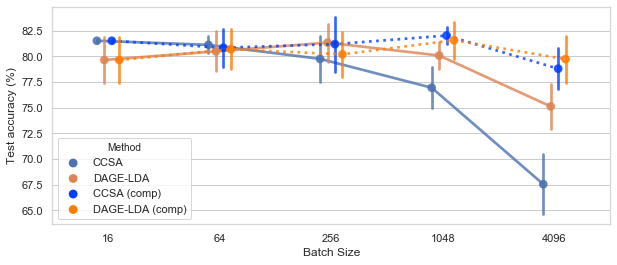

In [570]:
plt.figure(figsize=(10,4))
sns.set()
sns.set_style("whitegrid")
# sns.set_palette(sns.color_palette(None, 2))
ax = sns.pointplot(x='Batch Size', y='acc', hue='Method', dodge=0.2, data=get_batch_size_results('A->D'), ci='sd', linewidth=1, 
#                    linestyles=[':',':','-','-'], 
                   linestyles=['-','-',':',':'], 
                   palette=[*sns.color_palette('deep', 2), *sns.color_palette('bright', 2)])
# ax = sns.violinplot(x='Batch Size', y='acc', hue='Method', kind="point", data=get_batch_size_results('A->D'))
# ax = sns.lineplot(x='Batch Size', y='acc', hue='Method', err_style="bars", ci=68, data=get_batch_size_results('A->D'))
plt.setp(ax.get_children(),alpha=.8)
plt.xlabel('Batch Size')
plt.ylabel('Test accuracy (%)')
ax.figsize=(10,4)

# plt.xticks([16, 64, 254, 1024, 4096])
# plt.legend(loc='lower left')
# plt.ylim((60,74))
plt.savefig('batch_size-AD-line.pdf') 
